### Import

In [14]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import datetime

### Load Data

In [3]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [4]:

df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature Engineering

In [5]:
# Feature Engineering: days_until_next_order
df_date_only = pd.to_datetime(df_main['createdAt']).dt.date
df_main['only_date'] = df_date_only
df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days

In [6]:
# Feature Engineering: orders_last_365d
df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

### Data Preparation

In [7]:
num_cols = ['subtotal', 'travelingExpense', 'discountNum', 'isServicePackageBooking', 'orders_last_365d']
cat_cols = ['defaultPaymentMethod', 'mode', 'serviceClassificationName', 'state',
            'address_county', 'address_district', 'discount_type']
X = df_main[num_cols + cat_cols].copy()
y = df_main['days_until_next_order'].apply(lambda x: 0 if pd.isna(x) or x > 365 else 1)
groups = df_main["user_oid"]

for col in cat_cols:
    X[col] = X[col].astype(str)

### Pipeline

In [8]:
prep = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols)
    ],
    remainder='drop'
)

# Base Learners
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    random_state=42,
    class_weight='balanced'
)

catboost = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=0
)

# Train-Test Split
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Stacking: Generate out-of-fold predictions for training set
gss_inner = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
lgbm_oof_preds = np.zeros(len(train_idx))
catboost_oof_preds = np.zeros(len(train_idx))

for fold, (train_inner_idx, val_idx) in enumerate(gss_inner.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx])):
    # Train LGBM
    lgbm_pipe = Pipeline([('prep', prep), ('model', lgbm)])
    lgbm_pipe.fit(X.iloc[train_idx].iloc[train_inner_idx], y.iloc[train_idx].iloc[train_inner_idx])
    lgbm_oof_preds[val_idx] = lgbm_pipe.predict_proba(X.iloc[train_idx].iloc[val_idx])[:, 1]
    
    # Train CatBoost
    catboost_pipe = Pipeline([('prep', prep), ('model', catboost)])
    catboost_pipe.fit(X.iloc[train_idx].iloc[train_inner_idx], y.iloc[train_idx].iloc[train_inner_idx])
    catboost_oof_preds[val_idx] = catboost_pipe.predict_proba(X.iloc[train_idx].iloc[val_idx])[:, 1]

# Train base models on full training data
lgbm_pipe = Pipeline([('prep', prep), ('model', lgbm)])
lgbm_pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
lgbm_test_preds = lgbm_pipe.predict_proba(X.iloc[test_idx])[:, 1]

catboost_pipe = Pipeline([('prep', prep), ('model', catboost)])
catboost_pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
catboost_test_preds = catboost_pipe.predict_proba(X.iloc[test_idx])[:, 1]

# Prepare meta-features
meta_train = np.column_stack((lgbm_oof_preds, catboost_oof_preds))
meta_test = np.column_stack((lgbm_test_preds, catboost_test_preds))

# Train Meta-Learner (Logistic Regression)
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(meta_train, y.iloc[train_idx])

[LightGBM] [Info] Number of positive: 5932, number of negative: 11839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 17771, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6039, number of negative: 11858
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 17897, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5848, number of negative: 11829
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 17677, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5865, number of negative: 11855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 17720, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5708, number of negative: 11842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 17550, number of used features: 139
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7441, number of negative: 14813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 22254, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LogisticRegression(random_state=42)

### Prediction

In [9]:
# Final Predictions
pred_proba = meta_learner.predict_proba(meta_test)[:, 1]

### Threshold Adjustment

In [10]:
# Find Optimal Threshold (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], pred_proba)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Adjust predictions based on the optimal threshold
pred_adjusted = (pred_proba >= optimal_threshold).astype(int)

Optimal Threshold (Youden's J): 0.4296


### Eval

In [11]:
# Evaluation
print(f"\nAccuracy (Adjusted Threshold): {accuracy_score(y.iloc[test_idx], pred_adjusted):.2f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y.iloc[test_idx], pred_adjusted))


Accuracy (Adjusted Threshold): 0.73

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3716
           1       0.61      0.51      0.56      1843

    accuracy                           0.73      5559
   macro avg       0.69      0.67      0.68      5559
weighted avg       0.72      0.73      0.72      5559



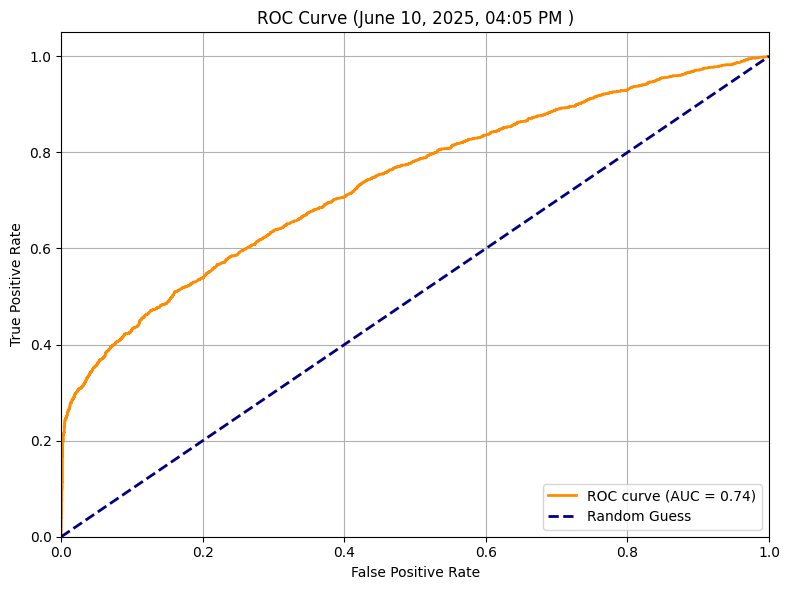

In [12]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y.iloc[test_idx], pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# G-Mean
cm_adjusted = confusion_matrix(y.iloc[test_idx], pred_adjusted)
recall_0 = cm_adjusted[0, 0] / (cm_adjusted[0, 0] + cm_adjusted[0, 1])
recall_1 = cm_adjusted[1, 1] / (cm_adjusted[1, 0] + cm_adjusted[1, 1])
gmean = np.sqrt(recall_0 * recall_1)
print(f"\nG-Mean (Adjusted Threshold): {gmean:.4f}")
print(f"Recall Class 0 (Specificity): {recall_0:.4f}")
print(f"Recall Class 1 (Sensitivity): {recall_1:.4f}")


G-Mean (Adjusted Threshold): 0.6543
Recall Class 0 (Specificity): 0.8402
Recall Class 1 (Sensitivity): 0.5095



Confusion Matrix (Adjusted Threshold):
[[3122  594]
 [ 904  939]]


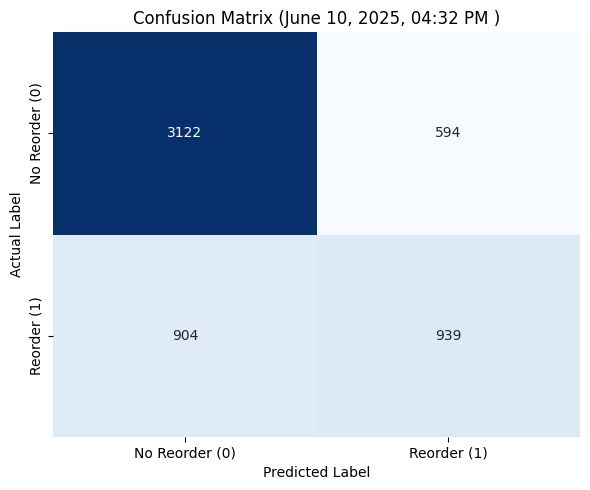

In [16]:
# Confusion Matrix
print("\nConfusion Matrix (Adjusted Threshold):")
print(cm_adjusted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Reorder (0)', 'Reorder (1)'],
            yticklabels=['No Reorder (0)', 'Reorder (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.tight_layout()
plt.show()